<a href="https://colab.research.google.com/github/CannS01/Car-Damage-Dataset-AI-Project/blob/main/Car_Damage_Detection_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet torch torchvision torchaudio
!pip install --quiet matplotlib seaborn
!pip install --quiet opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.5 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!pip install kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cansalman","key":"6cc5036911c7acf1b8e11ba746ca1c34"}'}

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
import kaggle
dataset = kaggle.api.dataset_download_files('samwash94/comprehensive-car-damage-detection', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/samwash94/comprehensive-car-damage-detection


In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

damage_map = {'Normal': 0, 'Crushed': 1, 'Breakage': 2}
view_map = {'F': 0, 'R': 1}

class MultiTaskCarDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            view_letter, damage_type = folder.split('_')
            view_label = view_map[view_letter]
            damage_label = damage_map[damage_type]

            for fname in os.listdir(folder_path):
                if fname.endswith('.jpg'):
                    img_path = os.path.join(folder_path, fname)
                    self.samples.append((img_path, view_label, damage_label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, view_label, damage_label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(view_label), torch.tensor(damage_label)


In [9]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

dataset_path = "/content/dataset"

full_dataset = MultiTaskCarDataset(dataset_path, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train set: {len(train_dataset)} görüntü")
print(f"Validation set: {len(val_dataset)} görüntü")



Train set: 1592 görüntü
Validation set: 398 görüntü


In [10]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [11]:
dataset_path = "/content/dataset"
train_dataset = MultiTaskCarDataset(dataset_path, transform=train_transform)
val_dataset = MultiTaskCarDataset(dataset_path, transform=val_transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, _ = random_split(train_dataset, [train_size, val_size])
_, val_dataset = random_split(val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [12]:
import torch.nn as nn
import torchvision.models as models

class MultiTaskResNet50(nn.Module):
    def __init__(self, num_damage_classes=3, num_view_classes=2):
        super(MultiTaskResNet50, self).__init__()
        backbone = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        in_features = backbone.fc.in_features

        self.head_damage = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_damage_classes)
        )

        self.head_view = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_view_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        out_damage = self.head_damage(features)
        out_view = self.head_view(features)
        return out_damage, out_view

In [13]:
model = MultiTaskResNet50()
dummy_input = torch.randn(4, 3, 128, 128)
out_damage, out_view = model(dummy_input)

print(f"Damage output: {out_damage.shape}")
print(f"View output:   {out_view.shape}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


Damage output: torch.Size([4, 3])
View output:   torch.Size([4, 2])


In [14]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"  ⚠️ EarlyStopping Counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [15]:
early_stopping = EarlyStopping(patience=3)

In [16]:
import torch
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiTaskResNet50().to(device)
criterion_damage = nn.CrossEntropyLoss()
criterion_view = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

def train(model, train_loader, val_loader, optimizer, scheduler, criterion_damage, criterion_view, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_damage = 0
        correct_view = 0
        total_samples = 0

        for images, view_labels, damage_labels in train_loader:
            images = images.to(device)
            view_labels = view_labels.to(device)
            damage_labels = damage_labels.to(device)

            out_damage, out_view = model(images)

            loss_damage = criterion_damage(out_damage, damage_labels)
            loss_view = criterion_view(out_view, view_labels)
            loss = loss_damage + loss_view

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, pred_damage = torch.max(out_damage, 1)
            _, pred_view = torch.max(out_view, 1)

            correct_damage += (pred_damage == damage_labels).sum().item()
            correct_view += (pred_view == view_labels).sum().item()
            total_samples += images.size(0)
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        acc_damage = 100 * correct_damage / total_samples
        acc_view = 100 * correct_view / total_samples
        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {avg_loss:.4f} | Damage Acc: {acc_damage:.2f}% | View Acc: {acc_view:.2f}%")

        # Validation
        model.eval()
        val_loss = 0
        val_correct_damage = 0
        val_correct_view = 0
        val_total = 0

        with torch.no_grad():
            for images, view_labels, damage_labels in val_loader:
                images = images.to(device)
                view_labels = view_labels.to(device)
                damage_labels = damage_labels.to(device)

                out_damage, out_view = model(images)

                loss_damage = criterion_damage(out_damage, damage_labels)
                loss_view = criterion_view(out_view, view_labels)
                loss = loss_damage + loss_view
                val_loss += loss.item()

                _, pred_damage = torch.max(out_damage, 1)
                _, pred_view = torch.max(out_view, 1)

                val_correct_damage += (pred_damage == damage_labels).sum().item()
                val_correct_view += (pred_view == view_labels).sum().item()
                val_total += images.size(0)

        val_avg_loss = val_loss / len(val_loader)
        val_acc_damage = 100 * val_correct_damage / val_total
        val_acc_view = 100 * val_correct_view / val_total

        print(f"               → Val Loss: {val_avg_loss:.4f} | Damage Acc: {val_acc_damage:.2f}% | View Acc: {val_acc_view:.2f}%")

        scheduler.step()

In [17]:
train(model, train_loader, val_loader, optimizer, scheduler,
      criterion_damage, criterion_view, device, num_epochs=10)

[Epoch 1/10] Train Loss: 1.1811 | Damage Acc: 53.71% | View Acc: 90.95%
               → Val Loss: 0.8112 | Damage Acc: 67.34% | View Acc: 99.75%
[Epoch 2/10] Train Loss: 0.6932 | Damage Acc: 72.11% | View Acc: 98.93%
               → Val Loss: 0.5329 | Damage Acc: 79.40% | View Acc: 99.75%
[Epoch 3/10] Train Loss: 0.4980 | Damage Acc: 80.53% | View Acc: 99.50%
               → Val Loss: 0.3756 | Damage Acc: 86.68% | View Acc: 99.50%
[Epoch 4/10] Train Loss: 0.3705 | Damage Acc: 86.12% | View Acc: 99.37%
               → Val Loss: 0.2644 | Damage Acc: 91.21% | View Acc: 99.75%
[Epoch 5/10] Train Loss: 0.2538 | Damage Acc: 91.02% | View Acc: 99.62%
               → Val Loss: 0.2385 | Damage Acc: 91.96% | View Acc: 100.00%
[Epoch 6/10] Train Loss: 0.2004 | Damage Acc: 93.72% | View Acc: 99.69%
               → Val Loss: 0.1907 | Damage Acc: 93.72% | View Acc: 100.00%
[Epoch 7/10] Train Loss: 0.1460 | Damage Acc: 95.67% | View Acc: 99.69%
               → Val Loss: 0.1869 | Damage Acc: 93

In [18]:
!pip install -q scikit-learn


In [19]:
from sklearn.metrics import classification_report

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds_damage = []
    all_labels_damage = []
    all_preds_view = []
    all_labels_view = []

    with torch.no_grad():
        for images, view_labels, damage_labels in data_loader:
            images = images.to(device)
            view_labels = view_labels.to(device)
            damage_labels = damage_labels.to(device)

            out_damage, out_view = model(images)

            _, pred_damage = torch.max(out_damage, 1)
            _, pred_view = torch.max(out_view, 1)

            all_preds_damage.extend(pred_damage.cpu().numpy())
            all_labels_damage.extend(damage_labels.cpu().numpy())

            all_preds_view.extend(pred_view.cpu().numpy())
            all_labels_view.extend(view_labels.cpu().numpy())

    print("🔧 Classification Report: DAMAGE (Normal / Crushed / Breakage)")
    print(classification_report(
        all_labels_damage,
        all_preds_damage,
        target_names=["Normal", "Crushed", "Breakage"]
    ))

    print("🔧 Classification Report: VIEW (Front / Rear)")
    print(classification_report(
        all_labels_view,
        all_preds_view,
        target_names=["Front", "Rear"]
    ))


In [20]:
evaluate_model(model, val_loader, device)


🔧 Classification Report: DAMAGE (Normal / Crushed / Breakage)
              precision    recall  f1-score   support

      Normal       0.98      0.91      0.95        94
     Crushed       0.90      0.96      0.93       141
    Breakage       0.96      0.94      0.95       163

    accuracy                           0.94       398
   macro avg       0.95      0.94      0.94       398
weighted avg       0.94      0.94      0.94       398

🔧 Classification Report: VIEW (Front / Rear)
              precision    recall  f1-score   support

       Front       1.00      1.00      1.00       223
        Rear       1.00      1.00      1.00       175

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398



In [21]:
torch.save(model.state_dict(), "/content/multitask_resnet50.pth")

In [23]:
import torch.nn as nn
import torchvision.models as models

class MultiTaskDenseNet121(nn.Module):
    def __init__(self, num_damage_classes=3, num_view_classes=2):
        super(MultiTaskDenseNet121, self).__init__()
        base_model = models.densenet121(pretrained=True)
        self.features = base_model.features

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        in_features = 1024

        self.head_damage = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_damage_classes)
        )

        self.head_view = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_view_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        out_damage = self.head_damage(x)
        out_view = self.head_view(x)
        return out_damage, out_view


In [24]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskDenseNet121().to(device)

criterion_damage = nn.CrossEntropyLoss()
criterion_view = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 162MB/s] 


In [25]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"  ⚠️ EarlyStopping Counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [26]:
early_stopping = EarlyStopping(patience=3)

In [27]:
def train(model, train_loader, val_loader, optimizer, scheduler, criterion_damage, criterion_view, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_damage = 0
        correct_view = 0
        total_samples = 0

        for images, view_labels, damage_labels in train_loader:
            images = images.to(device)
            view_labels = view_labels.to(device)
            damage_labels = damage_labels.to(device)

            out_damage, out_view = model(images)
            loss_damage = criterion_damage(out_damage, damage_labels)
            loss_view = criterion_view(out_view, view_labels)
            loss = loss_damage + loss_view

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, pred_damage = torch.max(out_damage, 1)
            _, pred_view = torch.max(out_view, 1)

            correct_damage += (pred_damage == damage_labels).sum().item()
            correct_view += (pred_view == view_labels).sum().item()
            total_samples += images.size(0)
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        acc_damage = 100 * correct_damage / total_samples
        acc_view = 100 * correct_view / total_samples
        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {avg_loss:.4f} | Damage Acc: {acc_damage:.2f}% | View Acc: {acc_view:.2f}%")

        # Validation
        model.eval()
        val_loss = 0
        val_correct_damage = 0
        val_correct_view = 0
        val_total = 0

        with torch.no_grad():
            for images, view_labels, damage_labels in val_loader:
                images = images.to(device)
                view_labels = view_labels.to(device)
                damage_labels = damage_labels.to(device)

                out_damage, out_view = model(images)
                loss_damage = criterion_damage(out_damage, damage_labels)
                loss_view = criterion_view(out_view, view_labels)
                loss = loss_damage + loss_view
                val_loss += loss.item()

                _, pred_damage = torch.max(out_damage, 1)
                _, pred_view = torch.max(out_view, 1)

                val_correct_damage += (pred_damage == damage_labels).sum().item()
                val_correct_view += (pred_view == view_labels).sum().item()
                val_total += images.size(0)

        val_avg_loss = val_loss / len(val_loader)
        val_acc_damage = 100 * val_correct_damage / val_total
        val_acc_view = 100 * val_correct_view / val_total
        print(f"               → Val Loss: {val_avg_loss:.4f} | Damage Acc: {val_acc_damage:.2f}% | View Acc: {val_acc_view:.2f}%")

        scheduler.step()

        early_stopping(val_avg_loss)
        if early_stopping.early_stop:
            print("⛔ Early stopping triggered. Training stopped.")
            break


In [28]:
train(model, train_loader, val_loader, optimizer, scheduler,
      criterion_damage, criterion_view, device, num_epochs=30)


[Epoch 1/30] Train Loss: 1.5131 | Damage Acc: 49.12% | View Acc: 77.76%
               → Val Loss: 1.1384 | Damage Acc: 60.80% | View Acc: 95.23%
[Epoch 2/30] Train Loss: 1.0180 | Damage Acc: 61.49% | View Acc: 96.80%
               → Val Loss: 0.8345 | Damage Acc: 68.84% | View Acc: 98.24%
[Epoch 3/30] Train Loss: 0.7940 | Damage Acc: 70.29% | View Acc: 98.12%
               → Val Loss: 0.6359 | Damage Acc: 76.38% | View Acc: 99.25%
[Epoch 4/30] Train Loss: 0.6516 | Damage Acc: 76.38% | View Acc: 98.87%
               → Val Loss: 0.5661 | Damage Acc: 80.65% | View Acc: 99.25%
[Epoch 5/30] Train Loss: 0.5963 | Damage Acc: 77.64% | View Acc: 99.06%
               → Val Loss: 0.5022 | Damage Acc: 82.16% | View Acc: 99.25%
[Epoch 6/30] Train Loss: 0.5310 | Damage Acc: 80.34% | View Acc: 99.56%
               → Val Loss: 0.4475 | Damage Acc: 85.68% | View Acc: 99.75%
[Epoch 7/30] Train Loss: 0.4590 | Damage Acc: 83.86% | View Acc: 99.37%
               → Val Loss: 0.4166 | Damage Acc: 85.9

In [30]:
import matplotlib.pyplot as plt

def plot_separate_losses(damage_train, damage_val, view_train, view_val):
    epochs = range(1, len(damage_train) + 1)

    plt.figure(figsize=(14, 6))

    # Damage loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, damage_train, label='Train Damage Loss')
    plt.plot(epochs, damage_val, label='Val Damage Loss')
    plt.title('Damage Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # View loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, view_train, label='Train View Loss')
    plt.plot(epochs, view_val, label='Val View Loss')
    plt.title('View Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [32]:
torch.save(model.state_dict(), "/content/densenet121.pth")

In [33]:
from google.colab import files
files.download("/content/densenet121.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
!pip install -q scikit-learn


In [35]:
from sklearn.metrics import classification_report
import torch

def evaluate_classification_report(model, data_loader, device):
    model.eval()
    all_preds_damage = []
    all_labels_damage = []
    all_preds_view = []
    all_labels_view = []

    with torch.no_grad():
        for images, view_labels, damage_labels in data_loader:
            images = images.to(device)
            view_labels = view_labels.to(device)
            damage_labels = damage_labels.to(device)

            out_damage, out_view = model(images)

            _, preds_damage = torch.max(out_damage, 1)
            _, preds_view = torch.max(out_view, 1)

            all_preds_damage.extend(preds_damage.cpu().numpy())
            all_labels_damage.extend(damage_labels.cpu().numpy())

            all_preds_view.extend(preds_view.cpu().numpy())
            all_labels_view.extend(view_labels.cpu().numpy())

    print("Classification Report: DAMAGE (Normal / Crushed / Breakage)")
    print(classification_report(all_labels_damage, all_preds_damage, target_names=["Normal", "Crushed", "Breakage"]))

    print("Classification Report: VIEW (Front / Rear)")
    print(classification_report(all_labels_view, all_preds_view, target_names=["Front", "Rear"]))


In [36]:
evaluate_classification_report(model, val_loader, device)


Classification Report: DAMAGE (Normal / Crushed / Breakage)
              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94        94
     Crushed       0.91      0.91      0.91       141
    Breakage       0.93      0.94      0.94       163

    accuracy                           0.93       398
   macro avg       0.93      0.93      0.93       398
weighted avg       0.93      0.93      0.93       398

Classification Report: VIEW (Front / Rear)
              precision    recall  f1-score   support

       Front       1.00      1.00      1.00       223
        Rear       0.99      1.00      1.00       175

    accuracy                           1.00       398
   macro avg       1.00      1.00      1.00       398
weighted avg       1.00      1.00      1.00       398



In [37]:
torch.save(model.state_dict(), "multitask_densenet121.pth")


In [38]:
torch.save(model, "full_model.pth")


In [39]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [40]:
def plot_confusion_matrices(model, data_loader, device):
    model.eval()
    all_preds_damage = []
    all_labels_damage = []
    all_preds_view = []
    all_labels_view = []

    with torch.no_grad():
        for images, view_labels, damage_labels in data_loader:
            images = images.to(device)
            view_labels = view_labels.to(device)
            damage_labels = damage_labels.to(device)

            out_damage, out_view = model(images)

            _, preds_damage = torch.max(out_damage, 1)
            _, preds_view = torch.max(out_view, 1)

            all_preds_damage.extend(preds_damage.cpu().numpy())
            all_labels_damage.extend(damage_labels.cpu().numpy())

            all_preds_view.extend(preds_view.cpu().numpy())
            all_labels_view.extend(view_labels.cpu().numpy())

    # DAMAGE MATRIX
    cm_damage = confusion_matrix(all_labels_damage, all_preds_damage)
    labels_damage = ["Normal", "Crushed", "Breakage"]

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_damage, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels_damage, yticklabels=labels_damage)
    plt.title("Confusion Matrix - Damage")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # VIEW MATRIX
    cm_view = confusion_matrix(all_labels_view, all_preds_view)
    labels_view = ["Front", "Rear"]

    plt.figure(figsize=(4,4))
    sns.heatmap(cm_view, annot=True, fmt="d", cmap="Greens",
                xticklabels=labels_view, yticklabels=labels_view)
    plt.title("Confusion Matrix - View")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


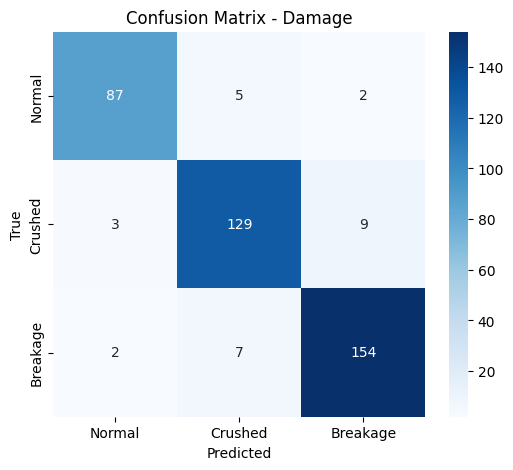

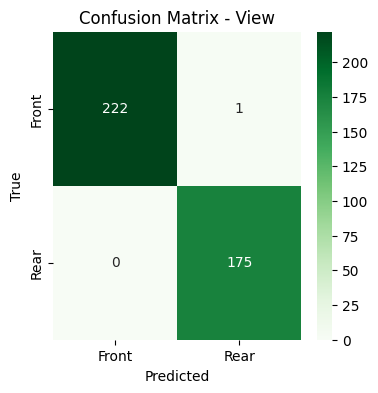

In [41]:
plot_confusion_matrices(model, val_loader, device)
